# Corona status in Finland

<i>Calculations by Reima Tuhkanen, reima.tuhkanen@intellinord.com, 2020-03-15</i>

Almost all COVID-19 cases in Finland are tested before 14.3.2020. It is known, that all the cases have not been tested, even if the person had symptoms of the disease, but the other criteria have not been met. How ever data is useful. <BR>
    
The disease will spread if preventive measures are not taken, ie social contacts are not minimized.<BR>
 

### Comments of this study

This study is based purely on math. No machine learning is used. It is also good to know, that when 60% of population has had the virus spread speed will decrease and when immunity level is about 90%, virus is not spreading any more. 

Sivun tiedot pohjautuvat Helsingin Sanomien julkaisemaan avoimeen dataan Suomen koronavirus-tartunnoista. HS on kerännyt aineiston julkisista lähteistä: tiedotustilaisuuksista, mediasta ja haastatteluista. Dataa päivitetään aina kun uusia tietoja tulee. https://github.com/HS-Datadesk/koronavirus-avoindata

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
import urllib.request as request
import json
import datetime
from scipy.optimize import curve_fit
from datetime import datetime, date, timedelta
import time
import matplotlib.dates as mdates

In [23]:
def func(x, a, b, c):
    return a * np.exp(b * x) + c

def predictTotal(Date,model):
    
    date_format = "%d.%m.%Y"
    start_date = datetime.strptime('26.02.2020', date_format)
    pred_date = datetime.strptime(Date, date_format)
    
    x = (pred_date-start_date).days
    return round(func(x, *model))

def predictNew(Date,model):
    
    date_format = "%d.%m.%Y"
    start_date = datetime.strptime('26.02.2020', date_format)
    pred_date = datetime.strptime(Date, date_format)
     
    
    x = (pred_date-start_date).days
    return round(func(x, *model) - func(x-1, *model))

## Death Rate
Death rate is not known. Data from different countries is measured different methods. Best estimation might be South Korea information, because testing is very active there. Closed cases (https://www.worldometers.info/coronavirus/country/south-korea/) shows currently 6.19% but it is still going down.  In China, (https://www.worldometers.info/coronavirus/country/china/) it is 4.49%, but testing is not so systematic than in South Korea. Tests are manufactured in South Korea.There are several different estimations, we use 3% here. <BR>
Study from S.Korea and Italy tells, that death peak is 5 days after confirmed peak. According China graphs, delay is longer, but China information is unclear, because diagnostics method was changed 12.2.2020.

In [24]:
def predictDeath(Date,model):
   
    date_format = "%d.%m.%Y"
    start_date = datetime.strptime('26.02.2020', date_format)
    pred_date = datetime.strptime(Date, date_format)
     
    
    x = (pred_date-start_date).days
    return round((func(x-5, *model) - func(x-6, *model))*0.03)

### Finnish Corona data from open data

In [25]:
url = 'https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData'

In [26]:
 with request.urlopen(url) as response:
        source = response.read()
        data = json.loads(source)

In [27]:
newdata = data['confirmed']
df = pd.DataFrame.from_dict(newdata)

In [28]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
confirmed = len(df)

### Chinese case in Lapland was separate case. We can drop that.

In [29]:
df = df[df['infectionSourceCountry'] != 'CHN']
df.sort_values('date',inplace = True)
df.tail()

,id,date,healthCareDistrict,infectionSourceCountry,infectionSource
291,294,2020-03-17,HUS,None,unknown
292,295,2020-03-17,HUS,None,unknown
293,296,2020-03-17,HUS,None,unknown
295,298,2020-03-17,HUS,None,unknown
316,325,2020-03-17,Pohjois-Savo,None,unknown


In [30]:
df1 = df.groupby('date').size().reset_index(name='New Cases')
df1 = df1.set_index(['date'])
df1['Cum'] = df1.cumsum()

### Drop current day, statistics for the current day is not ready

In [31]:
df1.reset_index(inplace = True)
df1['days'] = df1['date'].shift(-1) - df1['date']
df1['Cumdays'] = df1['days'].cumsum()
df1['Cumdays2'] = df1['Cumdays'].shift(1)
df1['Cumdays2'] = df1['Cumdays2'] / np.timedelta64(1, 'D')
df1 = df1.fillna(0.0)
df1.drop(['days', 'Cumdays'], axis=1, inplace=True)
df1.columns = ['date','New Cases','Cum','day']
df1.head(20)
df_malli = df1[df1['day']<18]
df_havainnot = df1[df1['day']>=18]


### New Confirmed Cases

Text(0.5, 1.0, 'New Confirmed Cases in Finland')

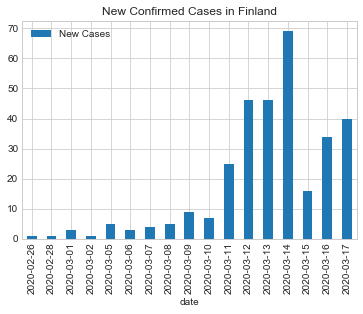

In [32]:
df1.plot(kind='bar',x='date',y='New Cases')
plt.title('New Confirmed Cases in Finland')

### Prediction Curve

Prediction curve has some limitations:
- Population in Finland is 5 540 000 people.
- The spread of the disease slows as the population's immunity increases.
- It is not known how effectively and how fast the social isolation will slow down the spread of the disease. Italy information can be used in the future. Social isolation started 17.3.2020 in Finland. 
- Testing criterias were changed on 15.3.2020. Only risk groups and cases that needs hospital care or people working in hospitals are tested. 

In [33]:
x = df_malli['day']
y = df_malli['Cum']
popt, pcov = curve_fit(func, x, y)
print("Function in Finland: " + str(popt[2]) + " + " + str(popt[1]) + "*10^(<days since 26.02.202>*" + str(popt[1]) + " )")


Function in Finland: 2.9850876577741374 + 0.40696229777701726*10^(<days since 26.02.202>*0.40696229777701726 )


### Cumulative cases fitted to function

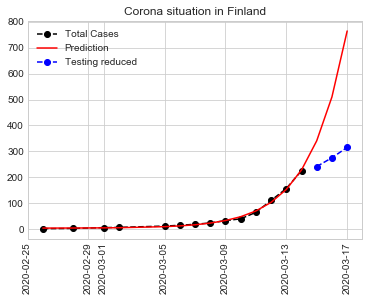

In [34]:
plt.figure()
plt.plot(df_malli['date'], y, 'ko--', label="Total Cases")
plt.plot(df1['date'], func(df1['day'], *popt), 'r-', label="Prediction")
plt.plot(df_havainnot['date'],df_havainnot['Cum'], 'bo--', label="Testing reduced")
plt.title('Corona situation in Finland')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### How many cases there will be on some specific day?

In the beginning of epidemy in Finland, 176/272 are in age of 25-54 years. Only 10 are older than 65 years. That explains very low mortality rate in the beginning of the epidemy in Finland. 

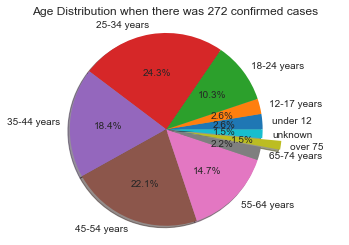

In [43]:
labels = 'under 12', '12-17 years','18-24 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65-74 years', 'over 75', 'unknown'
sizes = [7, 7,28,66,50,60,40,6,4,4]
explode = (0, 0,0,0,0,0,0,0,0.2,0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=0)
ax1.axis('equal') 
plt.title('Age Distribution when there was 272 confirmed cases')
plt.show()

### Predicting Near Future

In [44]:
note = ""
today = date.today()
for i in range(15):
    end_date = today + timedelta(days=i)
    day2 = end_date.strftime("%d.%m.%Y")
    prediction = predictTotal(day2,popt)
    predict_new = predictNew(day2,popt)
    deaths = predictDeath(day2,popt)
    if prediction > 110000:
        note = " "
    elif prediction > 74000:
        note = " China 18.2.2018. deaths 2000"
    elif prediction > 20000:
        note = " "
    elif prediction > 14800:
        note = " Hubei for Feb. 12: 14,840 new cases and 242 new deaths."
    elif prediction > 12800:
        note = " Italy 12.3.20200, deaths 1000."
    elif prediction > 12000:
        note = " Italy shut down 11.3.2020."
    elif prediction > 9000:
        note = " Italy strict quarantine measures extended to all regions. 9.3.2020"
    elif prediction > 6000:
        note = " Northern Italy under lockdown. 8.3.2020"
    elif prediction > 5000:
        note = " Entire region of Lombardy is in lockdown. 7.3.2020"
    elif prediction > 1000:
        note = ""
    elif prediction > 700:
        note = " First death in other countries when there has been over 800 cases."
    print(day2 + " total: " + str(int(prediction)) + ", new: "+ str(int(predict_new)) + " new deaths: " + str(int(deaths))  + note)

17.03.2020 total: 765, new: 255 new deaths: 1 First death in other countries when there has been over 800 cases.
18.03.2020 total: 1147, new: 383 new deaths: 2
19.03.2020 total: 1722, new: 575 new deaths: 2
20.03.2020 total: 2586, new: 863 new deaths: 3
21.03.2020 total: 3883, new: 1297 new deaths: 5
22.03.2020 total: 5832, new: 1949 new deaths: 8 Entire region of Lombardy is in lockdown. 7.3.2020
23.03.2020 total: 8759, new: 2927 new deaths: 11 Northern Italy under lockdown. 8.3.2020
24.03.2020 total: 13157, new: 4398 new deaths: 17 Italy 12.3.20200, deaths 1000.
25.03.2020 total: 19763, new: 6606 new deaths: 26 Hubei for Feb. 12: 14,840 new cases and 242 new deaths.
26.03.2020 total: 29687, new: 9924 new deaths: 39 
27.03.2020 total: 44596, new: 14909 new deaths: 58 
28.03.2020 total: 66993, new: 22397 new deaths: 88 
29.03.2020 total: 100639, new: 33646 new deaths: 132 China 18.2.2018. deaths 2000
30.03.2020 total: 151183, new: 50544 new deaths: 198 
31.03.2020 total: 227113, new: 7

### How many people are not aware having Corona today?

In [37]:
today = date.today()
end_date = today + timedelta(days=5)
day1 = today.strftime("%d.%m.%Y")
day2 = end_date.strftime("%d.%m.%Y")

print("Wash your hands, because " + str(predictTotal(day2,popt) - predictTotal(day1,popt)) + " people are out there without knowing having COVID-19!")

Wash your hands, because 5067.0 people are out there without knowing having COVID-19!


### Confirmed cases in Finland

In [38]:
print("There are " + str(confirmed) + " confirmed cases in Finland")

There are 317 confirmed cases in Finland


### Recovered cases in Finland

In [39]:
newdata = data['recovered']
recovered_df = pd.DataFrame.from_dict(newdata)
recovered = len(recovered_df)
print(str(recovered) + " persons has recovered from COVID-19")
print("That is " + str(round(100*recovered/confirmed)) + " % of confirmed cases")

10 persons has recovered from COVID-19
That is 3 % of confirmed cases


### Active Cases

In [40]:
print("There are " + str(confirmed - recovered) + " active cases in Finland officially")

There are 307 active cases in Finland officially


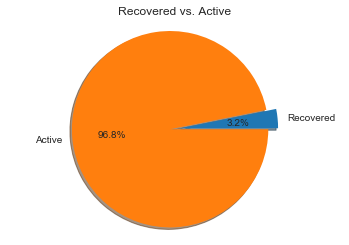

In [41]:
labels = 'Recovered', 'Active'
sizes = [recovered/confirmed, (confirmed - recovered)/confirmed]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=0)
ax1.axis('equal') 
plt.title('Recovered vs. Active')
plt.show()

### Deaths

In [42]:
newdata = data['deaths']
deaths_df = pd.DataFrame.from_dict(newdata)
deaths = len(deaths_df)
print(str(deaths) + " persons have died in Finland from COVID-19")
print("That is " + str(round(100*(deaths)/recovered+deaths)) + " % of confirmed cases")

0 persons have died in Finland from COVID-19
That is 0 % of confirmed cases
